In [ ]:
import os
import cv2
import numpy as np
import paddle
import paddle.nn as nn
import paddle.nn.functional as F
import paddle.vision.transforms as T
from paddle.io import Dataset, DataLoader
from paddle.vision.models import resnet50, mobilenet_v2  # 使用 ResNet50 作为教师模型，MobileNetV2 作为学生模型
from paddle.optimizer import Adam
from paddle.regularizer import L2Decay
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
import visualdl
import warnings
import math
import matplotlib.pyplot as plt

In [ ]:
warnings.filterwarnings("ignore", category=UserWarning, module='paddle.nn.layer.norm')

In [ ]:
#  启用动态图模式

paddle.disable_static()

In [2]:
#  设置随机种子以保证结果可复现

def set_seed(seed=42):
    np.random.seed(seed)
    paddle.seed(seed)

set_seed(42)

In [3]:
# 定义数据路径和分类标签

data_dir = "./data/data101031"  # 请确保此路径下有对应的分类文件夹
categories = ["Harmful", "Kitchen", "Other", "Recyclable"]  # 实际分类
num_classes = len(categories)
img_size = (224, 224)

In [4]:
# 定义自定义数据集类

class GarbageDataset(Dataset):
    def __init__(self, features, labels, transform=None):
        super(GarbageDataset, self).__init__()
        self.features = features
        self.labels = labels
        self.transform = transform

    def __getitem__(self, idx):
        image = self.features[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.features)

In [5]:
#  数据增强预处理

train_transform = T.Compose([
    T.RandomHorizontalFlip(prob=0.5),
    T.RandomVerticalFlip(prob=0.3),
    T.RandomRotation(degrees=30),
    T.RandomCrop(size=img_size, padding=8),
    T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    T.RandomErasing(prob=0.2),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [6]:
# Cell  定义辅助函数

def calculate_class_weights(labels):
    """
    计算类别权重，处理类别不平衡问题
    """
    unique_labels, counts = np.unique(labels, return_counts=True)
    weights = 1.0 / counts
    weights = weights / np.sum(weights) * len(unique_labels)
    return paddle.to_tensor(weights, dtype='float32')


def load_and_preprocess_data(data_dir, categories, img_size):
    """
    加载并预处理数据
    """
    features = []
    labels = []

    for label, category in enumerate(categories):
        folder_path = os.path.join(data_dir, category)
        if not os.path.exists(folder_path):
            warnings.warn(f"警告: 目录 {folder_path} 不存在")
            continue

        for img_file in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_file)
            if not os.path.isfile(img_path):
                continue  # 跳过非文件项
            try:
                img = cv2.imread(img_path)
                if img is None:
                    warnings.warn(f"警告: 无法读取图像 {img_path}")
                    continue

                if len(img.shape) == 2:
                    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
                else:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                img = cv2.resize(img, img_size)

                if img.shape[2] != 3:
                    warnings.warn(f"警告: 图像 {img_path} 不是3通道，跳过。")
                    continue

                features.append(img)
                labels.append(label)
            except Exception as e:
                warnings.warn(f"处理图像 {img_path} 时出错: {str(e)}")

    return np.array(features, dtype=np.uint8), np.array(labels, dtype=np.int64)


In [7]:
#  定义知识蒸馏损失函数

class DistillationLoss(nn.Layer):
    def __init__(self, temperature=4.0, alpha=0.5):
        super(DistillationLoss, self).__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.ce_loss = nn.CrossEntropyLoss()
        self.kl_loss = nn.KLDivLoss(reduction='batchmean')  # Kullback-Leibler 散度

    def forward(self, student_logits, teacher_logits, labels):
        """
        计算综合损失，包括交叉熵损失和KL散度损失
        """
        # 交叉熵损失
        ce = self.ce_loss(student_logits, labels)

        # 蒸馏损失
        soft_student = F.log_softmax(student_logits / self.temperature, axis=1)
        soft_teacher = F.softmax(teacher_logits / self.temperature, axis=1)
        kl = self.kl_loss(soft_student, soft_teacher) * (self.temperature ** 2)

        # 综合损失
        loss = self.alpha * ce + (1. - self.alpha) * kl
        return loss


In [8]:
# 定义教师模型

def get_teacher_model(num_classes, pretrained=True):
    """
    获取教师模型，并确保其输出为指定的类别数
    """
    # 尝试在初始化时设置 num_classes
    try:
        teacher = resnet50(pretrained=pretrained, num_classes=num_classes)
    except TypeError:
        # 如果不支持，在初始化后修改 fc 层
        teacher = resnet50(pretrained=pretrained)
        in_features = teacher.fc.weight.shape[1]  # 应为2048
        teacher.fc = nn.Linear(in_features, num_classes)

    # 冻结教师模型的参数
    for param in teacher.parameters():
        param.trainable = False

    teacher.eval()  # 设置为评估模式
    return teacher


In [9]:
# 定义学生模型（使用 MobileNetV2）

class GarbageClassifier(nn.Layer):
    def __init__(self, num_classes):
        super(GarbageClassifier, self).__init__()
        # 加载预训练的 MobileNetV2
        backbone = mobilenet_v2(pretrained=True)

        # 冻结部分特征提取层（根据需要调整冻结层数）
        for param in backbone.features[:14].parameters():  # 冻结前14层
            param.trainable = False

        self.features = backbone.features

        # 改进的分类头
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2D((1, 1)),
            nn.Flatten(),
            nn.Linear(backbone.last_channel, 1024),
            nn.BatchNorm1D(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)  # 确保输出为 num_classes
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [10]:
#  定义训练函数

def train_model(model, teacher_model, train_loader, val_loader, criterion, num_epochs=50, fold=0, device='cpu'):
    """
    训练模型并进行验证，包含知识蒸馏
    """
    # 定义优化器
    base_lr = 0.0001
    optimizer = Adam(
        learning_rate=base_lr,
        parameters=model.parameters(),
        weight_decay=L2Decay(0.0001)
    )

    # 初始化VisualDL
    log_writer = visualdl.LogWriter(logdir=f'./log/fold_{fold}')

    # 记录最佳验证准确率
    best_val_acc = 0.0
    patience = 10  # 提前停止的耐心值
    patience_counter = 0
    warmup_epochs = 5

    for epoch in range(num_epochs):
        train_correct = 0
        train_total = 0

        # 学习率预热和余弦退火
        if epoch < warmup_epochs:
            lr = base_lr * (epoch + 1) / warmup_epochs
        else:
            cosine_epoch = epoch - warmup_epochs
            total_cosine_epochs = num_epochs - warmup_epochs
            lr = base_lr * 0.5 * (1 + math.cos(math.pi * cosine_epoch / total_cosine_epochs))

        optimizer.set_lr(lr)  # 手动设置学习率
        print(f'Epoch [{epoch+1}/{num_epochs}], Learning Rate: {lr:.6f}')

        # 训练阶段
        model.train()
        train_loss = 0.0

        for batch_id, data in enumerate(train_loader):
            images, labels = data
            images = images.astype('float32')
            labels = labels.astype('int64')

            # 将数据移动到设备
            images = images.to(device)
            labels = labels.to(device)

            # 添加 Mixup 数据增强（在 warmup 之后）
            if epoch >= warmup_epochs:
                alpha = 0.2
                lam = np.random.beta(alpha, alpha)
                index = paddle.randperm(images.shape[0])
                mixed_images = lam * images + (1 - lam) * images[index]
                labels_a = labels
                labels_b = labels[index]
            else:
                mixed_images = images
                lam = 1.0
                labels_a = labels
                labels_b = labels

            # 学生模型输出
            student_logits = model(mixed_images)

            # 教师模型输出（不需要梯度）
            with paddle.no_grad():
                teacher_logits = teacher_model(images)

            # 确保教师和学生输出维度匹配
            if student_logits.shape != teacher_logits.shape:
                raise ValueError(f"教师模型输出形状 {teacher_logits.shape} 与学生模型输出形状 {student_logits.shape} 不匹配。")

            # 计算蒸馏损失
            loss = criterion(student_logits, teacher_logits, labels_a)

            loss.backward()
            optimizer.step()
            optimizer.clear_grad()

            train_loss += loss.item()

            # 计算预测结果
            preds = paddle.argmax(student_logits, axis=1)

            # 更新手动准确率
            if epoch >= warmup_epochs:
                train_correct += (lam * (preds == labels_a).astype('float32') + 
                                  (1 - lam) * (preds == labels_b).astype('float32')).sum().item()
            else:
                train_correct += (preds == labels_a).astype('float32').sum().item()
            train_total += labels_a.shape[0]

            if batch_id % 5 == 0:
                current_acc = train_correct / train_total if train_total > 0 else 0
                print(f'Epoch [{epoch+1}/{num_epochs}], '
                      f'Step [{batch_id}/{len(train_loader)}], '
                      f'Loss: {loss.item():.4f}, '
                      f'Acc: {current_acc:.4f}')

        avg_train_loss = train_loss / len(train_loader)
        avg_train_acc = train_correct / train_total if train_total > 0 else 0

        # 验证阶段
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []

        with paddle.no_grad():
            for images, labels in val_loader:
                images = images.astype('float32')
                labels = labels.astype('int64')
                images = images.to(device)
                labels = labels.to(device)

                # 学生模型输出
                logits = model(images)

                # 教师模型输出
                teacher_logits = teacher_model(images)

                # 确保教师和学生输出维度匹配
                if logits.shape != teacher_logits.shape:
                    raise ValueError(f"教师模型输出形状 {teacher_logits.shape} 与学生模型输出形状 {logits.shape} 不匹配。")

                # 计算蒸馏损失
                loss = criterion(logits, teacher_logits, labels)

                preds = paddle.argmax(logits, axis=1)
                all_preds.extend(preds.cpu().numpy().tolist())
                all_labels.extend(labels.cpu().numpy().tolist())

                val_loss += loss.item()
                correct += (preds == labels).astype('float32').sum().item()
                total += labels.shape[0]

        avg_val_loss = val_loss / len(val_loader)
        manual_acc = correct / total if total > 0 else 0  # 手动准确率

        # 记录训练日志
        log_writer.add_scalar(tag='train/loss', step=epoch, value=avg_train_loss)
        log_writer.add_scalar(tag='train/acc', step=epoch, value=avg_train_acc)
        log_writer.add_scalar(tag='val/loss', step=epoch, value=avg_val_loss)
        log_writer.add_scalar(tag='val/acc', step=epoch, value=manual_acc)

        print(f'\nEpoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}')
        print(f'Val Loss: {avg_val_loss:.4f}, Val Acc: {manual_acc:.4f}')

        print("\n验证集分类报告:")
        print(classification_report(all_labels, all_preds, target_names=categories))

        # 保存最佳模型
        if manual_acc > best_val_acc:
            best_val_acc = manual_acc
            os.makedirs('models', exist_ok=True)
            paddle.save(model.state_dict(), f'models/best_model_fold{fold}.pdparams')
            print(f'最佳模型已保存 (Val Acc: {best_val_acc:.4f})')
            patience_counter = 0
        else:
            patience_counter += 1
            print(f'验证准确率未提升 ({patience_counter}/{patience})')

        # 提前停止
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break


In [11]:
#  定义主函数

def main():
    # 检查是否有可用 GPU
    device = 'gpu' if paddle.is_compiled_with_cuda() else 'cpu'
    paddle.set_device(device)
    print(f'使用设备: {device}')

    # 加载数据
    print("加载数据...")
    X, y = load_and_preprocess_data(data_dir, categories, img_size)

    if len(X) == 0:
        raise ValueError("没有找到任何有效的图像数据！")

    print(f'数据集总样本数: {len(X)}')
    print(f'类别分布: {np.bincount(y)}')

    # 显示前5张图像及其标签（调试）
    print("\n显示前5张图像及其标签:")
    for i in range(min(5, len(X))):
        img = X[i]
        label = y[i]
        plt.imshow(img)
        plt.title(categories[label])
        plt.axis('off')
        plt.show()

    # 初始化教师模型
    print("加载教师模型...")
    teacher_model = get_teacher_model(num_classes=num_classes, pretrained=True)
    teacher_model.to(device)

    # K-Fold Cross Validation 使用交叉验证
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_scores = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"\n开始训练第 {fold+1} fold...")

        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # 计算类别权重
        class_weights = calculate_class_weights(y_train)
        print("类别权重:", class_weights.cpu().numpy())

        # 创建数据集
        train_dataset = GarbageDataset(X_train, y_train, transform=train_transform)
        val_dataset = GarbageDataset(X_val, y_val, transform=test_transform)

        # 创建数据加载器
        train_loader = DataLoader(
            train_dataset,
            batch_size=16,
            shuffle=True,
            num_workers=0
        )
        val_loader = DataLoader(
            val_dataset,
            batch_size=16,
            shuffle=False,
            num_workers=0
        )

        # 创建学生模型
        model = GarbageClassifier(num_classes=num_classes)
        model = model.to(device)

        # 定义知识蒸馏损失函数
        criterion = DistillationLoss(temperature=4.0, alpha=0.5)

        # 训练模型
        try:
            train_model(
                model, teacher_model,
                train_loader, val_loader,
                criterion, num_epochs=50,
                fold=fold, device=device
            )
        except Exception as e:
            print(f"Fold {fold+1} 训练过程中出现错误: {e}")
            continue

        # 加载最佳模型进行评估
        best_model_path = f'models/best_model_fold{fold}.pdparams'
        if os.path.exists(best_model_path):
            model.set_state_dict(paddle.load(best_model_path))
            model.eval()

            # 评估最佳模型
            all_preds = []
            all_labels = []
            correct = 0
            total = 0

            with paddle.no_grad():
                for batch_id, (images, labels) in enumerate(val_loader):
                    images = images.astype('float32')
                    labels = labels.astype('int64')
                    images = images.to(device)
                    labels = labels.to(device)

                    logits = model(images)
                    preds = paddle.argmax(logits, axis=1)
                    all_preds.extend(preds.cpu().numpy().tolist())
                    all_labels.extend(labels.cpu().numpy().tolist())

                    correct += (preds == labels).astype('float32').sum().item()
                    total += labels.shape[0]

            fold_acc = correct / total if total > 0 else 0
            fold_scores.append(fold_acc)

            print(f"\n第 {fold+1} fold最终评估:")
            print(f"准确率: {fold_acc:.4f}")
            print("\n分类报告:")
            print(classification_report(all_labels, all_preds, target_names=categories))
            print("\n混淆矩阵:")
            print(confusion_matrix(all_labels, all_preds))
        else:
            print(f"警告: 最佳模型文件 {best_model_path} 不存在。")

    # 打印平均性能
    if fold_scores:
        print("\n交叉验证结果:")
        print(f"平均准确率: {np.mean(fold_scores):.4f} ± {np.std(fold_scores):.4f}")
    else:
        print("\n没有成功完成任何 fold 的训练和评估。")


/opt/conda/envs/python35-paddle120-env/lib/python3.10/site-packages/paddle/utils/cpp_extension/extension_utils.py:686: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)


使用设备: gpu
加载数据...


Premature end of JPEG file


数据集总样本数: 64000
类别分布: [16000 16000 16000 16000]

显示前5张图像及其标签:


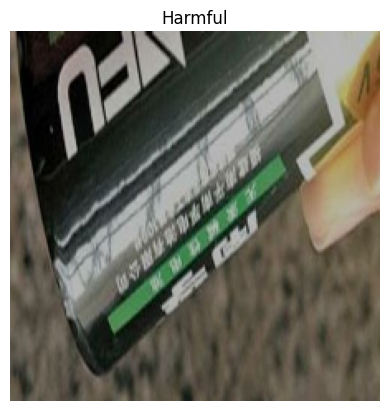

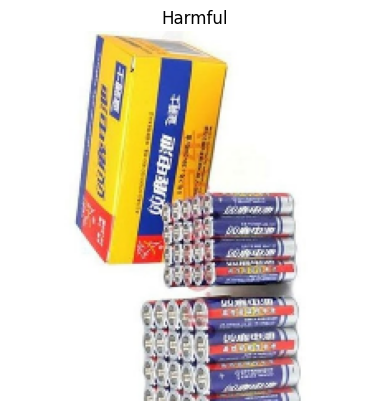

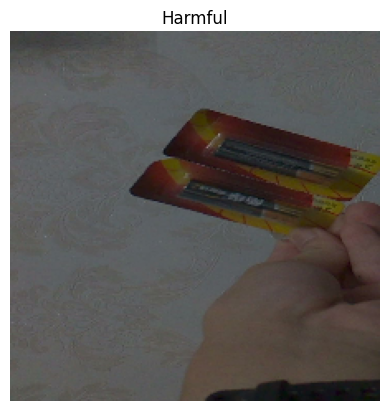

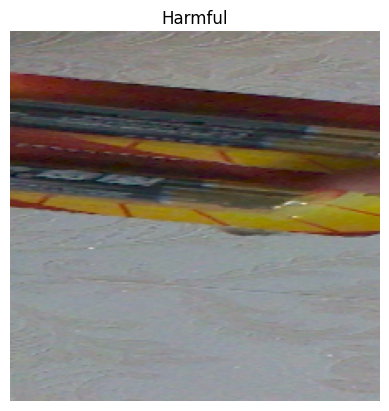

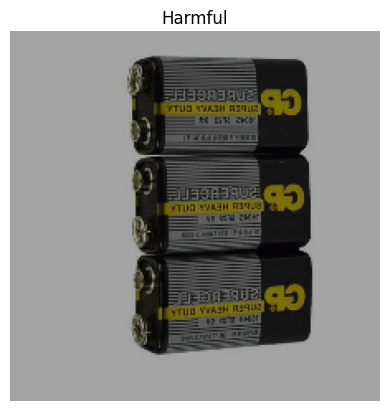

加载教师模型...


W1230 16:45:20.423480 25462 gpu_resources.cc:119] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 12.0, Runtime API Version: 11.8
W1230 16:45:20.424692 25462 gpu_resources.cc:164] device: 0, cuDNN Version: 8.9.
/opt/conda/envs/python35-paddle120-env/lib/python3.10/site-packages/paddle/nn/layer/layers.py:2194: UserWarning: Skip loading for fc.weight. fc.weight receives a shape [2048, 1000], but the expected shape is [2048, 4].
  warnings.warn(f"Skip loading for {key}. " + str(err))
/opt/conda/envs/python35-paddle120-env/lib/python3.10/site-packages/paddle/nn/layer/layers.py:2194: UserWarning: Skip loading for fc.bias. fc.bias receives a shape [1000], but the expected shape is [4].
  warnings.warn(f"Skip loading for {key}. " + str(err))



开始训练第 1 fold...
类别权重: [0.9983556 0.996956  1.0011668 1.0035216]


100%|██████████| 20795/20795 [00:00<00:00, 85110.49it/s]


Epoch [8/50], Step [495/3200], Loss: 0.5841, Acc: 0.8614
Epoch [8/50], Step [500/3200], Loss: 0.8762, Acc: 0.8617
Epoch [8/50], Step [505/3200], Loss: 0.5245, Acc: 0.8616
Epoch [8/50], Step [510/3200], Loss: 0.8866, Acc: 0.8625
Epoch [8/50], Step [515/3200], Loss: 0.5742, Acc: 0.8628
Epoch [8/50], Step [520/3200], Loss: 0.6590, Acc: 0.8623
Epoch [8/50], Step [525/3200], Loss: 0.5606, Acc: 0.8624
Epoch [8/50], Step [530/3200], Loss: 0.5070, Acc: 0.8632
Epoch [8/50], Step [535/3200], Loss: 0.6247, Acc: 0.8625
Epoch [8/50], Step [540/3200], Loss: 0.8223, Acc: 0.8627
Epoch [8/50], Step [545/3200], Loss: 0.7472, Acc: 0.8628
Epoch [8/50], Step [550/3200], Loss: 0.7753, Acc: 0.8627
Epoch [8/50], Step [555/3200], Loss: 0.7522, Acc: 0.8627
Epoch [8/50], Step [560/3200], Loss: 0.5232, Acc: 0.8627
Epoch [8/50], Step [565/3200], Loss: 0.6012, Acc: 0.8615
Epoch [8/50], Step [570/3200], Loss: 0.6038, Acc: 0.8607
Epoch [8/50], Step [575/3200], Loss: 0.6040, Acc: 0.8606
Epoch [8/50], Step [580/3200], 

In [ ]:
#  运行主函数

if __name__ == '__main__':
    main()

In [ ]:
# 导入必要的库和设置
import os
import cv2
import numpy as np
import paddle
import paddle.nn as nn
import paddle.nn.functional as F
import paddle.vision.transforms as T
from paddle.io import Dataset, DataLoader
from paddle.vision.models import resnet50, mobilenet_v2  # 使用 ResNet50 作为教师模型，MobileNetV2 作为学生模型
from paddle.optimizer import Adam
from paddle.regularizer import L2Decay
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
import visualdl
import warnings
import math
import matplotlib.pyplot as plt

# 忽略特定的警告
warnings.filterwarnings("ignore", category=UserWarning, module='paddle.nn.layer.norm')

# 启用动态图模式
paddle.disable_static()

# 设置随机种子以保证结果可复现
def set_seed(seed=42):
    np.random.seed(seed)
    paddle.seed(seed)

set_seed(42)

# 定义数据路径和分类标签
data_dir = "./data/data101031"  # 请确保此路径下有对应的分类文件夹
categories = ["Harmful", "Kitchen", "Other", "Recyclable"]  # 示例为四分类任务
num_classes = len(categories)  # 4
img_size = (224, 224)

# 定义自定义数据集类
class GarbageDataset(Dataset):
    def __init__(self, features, labels, transform=None):
        super(GarbageDataset, self).__init__()
        self.features = features
        self.labels = labels
        self.transform = transform

    def __getitem__(self, idx):
        image = self.features[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.features)

# 数据增强预处理
train_transform = T.Compose([
    T.RandomHorizontalFlip(prob=0.5),
    T.RandomVerticalFlip(prob=0.3),
    T.RandomRotation(degrees=30),
    T.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    T.RandomCrop(size=img_size, padding=8),
    T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    T.RandomErasing(prob=0.2),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 定义辅助函数
def calculate_class_weights(labels):
    """
    计算类别权重，处理类别不平衡问题
    """
    unique_labels, counts = np.unique(labels, return_counts=True)
    weights = 1.0 / counts
    weights = weights / np.sum(weights) * len(unique_labels)
    # 如果需要，手动增加某些类别的权重，例如：
    # weights[0] *= 1.5  # 对第一类增加权重
    # weights[2] *= 2.0  # 对第三类增加权重
    return paddle.to_tensor(weights, dtype='float32')

def load_and_preprocess_data(data_dir, categories, img_size):
    """
    加载并预处理数据
    """
    features = []
    labels = []

    for label, category in enumerate(categories):
        folder_path = os.path.join(data_dir, category)
        if not os.path.exists(folder_path):
            warnings.warn(f"警告: 目录 {folder_path} 不存在")
            continue

        for img_file in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_file)
            if not os.path.isfile(img_path):
                continue  # 跳过非文件项
            try:
                img = cv2.imread(img_path)
                if img is None:
                    warnings.warn(f"警告: 无法读取图像 {img_path}")
                    continue

                if len(img.shape) == 2:
                    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
                else:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                img = cv2.resize(img, img_size)

                if img.shape[2] != 3:
                    warnings.warn(f"警告: 图像 {img_path} 不是3通道，跳过。")
                    continue

                features.append(img)
                labels.append(label)
            except Exception as e:
                warnings.warn(f"处理图像 {img_path} 时出错: {str(e)}")

    return np.array(features, dtype=np.uint8), np.array(labels, dtype=np.int64)

# 定义知识蒸馏损失函数
class DistillationLoss(nn.Layer):
    def __init__(self, temperature=4.0, alpha=0.5, class_weights=None):
        super(DistillationLoss, self).__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.ce_loss = nn.CrossEntropyLoss(weight=class_weights)
        self.kl_loss = nn.KLDivLoss(reduction='batchmean')  # Kullback-Leibler 散度

    def forward(self, student_logits, teacher_logits, labels_a, labels_b=None, lam=1.0):
        """
        计算综合损失，包括交叉熵损失和KL散度损失
        """
        # 交叉熵损失
        ce = self.ce_loss(student_logits, labels_a)

        # 蒸馏损失
        soft_student = F.log_softmax(student_logits / self.temperature, axis=1)
        soft_teacher = F.softmax(teacher_logits / self.temperature, axis=1)
        kl = self.kl_loss(soft_student, soft_teacher) * (self.temperature ** 2)

        # 综合损失
        loss = self.alpha * ce + (1. - self.alpha) * kl
        return loss

# 定义教师模型
def get_teacher_model(num_classes, pretrained=True):
    """
    获取教师模型，并确保其输出为指定的类别数
    """
    # 尝试在初始化时设置 num_classes
    try:
        teacher = resnet50(pretrained=pretrained, num_classes=num_classes)
    except TypeError:
        # 如果不支持，在初始化后修改 fc 层
        teacher = resnet50(pretrained=pretrained)
        in_features = teacher.fc.weight.shape[1]  # 应为2048
        teacher.fc = nn.Linear(in_features, num_classes)
    
    # 冻结教师模型的参数
    for param in teacher.parameters():
        param.trainable = False

    teacher.eval()  # 设置为评估模式
    return teacher

# 定义学生模型（使用 MobileNetV2）
class GarbageClassifier(nn.Layer):
    def __init__(self, num_classes):
        super(GarbageClassifier, self).__init__()
        # 加载预训练的 MobileNetV2
        backbone = mobilenet_v2(pretrained=True)

        # 冻结部分特征提取层（根据需要调整冻结层数）
        for param in backbone.features[:14].parameters():  # 冻结前14层，根据需要调整
            param.trainable = False

        self.features = backbone.features

        # 改进的分类头
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2D((1, 1)),
            nn.Flatten(),
            nn.Linear(backbone.last_channel, 1024),
            nn.BatchNorm1D(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)  # 确保输出为 num_classes
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# 定义训练函数
def train_model(model, teacher_model, train_loader, val_loader, criterion, num_epochs=50, fold=0, device='cpu'):
    """
    训练模型并进行验证，包含知识蒸馏
    """
    # 定义优化器，并添加梯度裁剪
    base_lr = 0.0001
    optimizer = Adam(
        learning_rate=base_lr,  # 直接使用基准学习率
        parameters=model.parameters(),
        weight_decay=L2Decay(0.0001)
    )

    # 初始化VisualDL
    log_writer = visualdl.LogWriter(logdir=f'./log/fold_{fold}')

    # 记录最佳验证准确率
    best_val_acc = 0.0
    patience = 10  # 提前停止的耐心值
    patience_counter = 0
    warmup_epochs = 5

    for epoch in range(num_epochs):
        # 重新初始化手动准确率变量
        train_correct = 0
        train_total = 0

        # 学习率预热和余弦退火
        if epoch < warmup_epochs:
            lr = base_lr * (epoch + 1) / warmup_epochs
        else:
            cosine_epoch = epoch - warmup_epochs
            total_cosine_epochs = num_epochs - warmup_epochs
            lr = base_lr * 0.5 * (1 + math.cos(math.pi * cosine_epoch / total_cosine_epochs))

        optimizer.set_lr(lr)  # 手动设置学习率
        print(f'Epoch [{epoch+1}/{num_epochs}], Learning Rate: {lr:.6f}')

        # 训练阶段
        model.train()
        train_loss = 0.0
        train_ce_loss = 0.0
        train_kl_loss = 0.0

        for batch_id, data in enumerate(train_loader):
            images, labels = data
            images = images.astype('float32')
            labels = labels.astype('int64')

            # 将数据移动到设备
            images = images.to(device)
            labels = labels.to(device)

            # 添加 Mixup 数据增强
            if epoch >= warmup_epochs:
                alpha = 0.2
                lam = np.random.beta(alpha, alpha)
                index = paddle.randperm(images.shape[0])
                mixed_images = lam * images + (1 - lam) * images[index]
                labels_a = labels
                labels_b = labels[index]
            else:
                mixed_images = images
                lam = 1.0
                labels_a = labels
                labels_b = labels

            # 学生模型输出
            student_logits = model(mixed_images)

            # 教师模型输出（不需要梯度）
            with paddle.no_grad():
                teacher_logits = teacher_model(images)

            # 确保教师和学生输出维度匹配
            if student_logits.shape != teacher_logits.shape:
                raise ValueError(f"教师模型输出形状 {teacher_logits.shape} 与学生模型输出形状 {student_logits.shape} 不匹配。")

            # 计算蒸馏损失
            loss = criterion(student_logits, teacher_logits, labels_a)

            loss.backward()
            # 应用梯度裁剪
            paddle.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()
            optimizer.clear_grad()

            train_loss += loss.item()

            # 计算交叉熵和KL散度损失
            # （假设 DistillationLoss 返回综合损失，不单独返回 ce 和 kl）
            # 如果需要单独记录 ce 和 kl，请修改 DistillationLoss 类以返回它们

            # 计算预测结果
            preds = paddle.argmax(student_logits, axis=1)

            # 更新手动准确率
            if epoch >= warmup_epochs:
                train_correct += (lam * (preds == labels_a).astype('float32') + (1 - lam) * (preds == labels_b).astype('float32')).sum().item()
            else:
                train_correct += (preds == labels_a).astype('float32').sum().item()
            train_total += labels_a.shape[0]

            if batch_id % 5 == 0:
                current_acc = train_correct / train_total if train_total > 0 else 0
                print(f'Epoch [{epoch+1}/{num_epochs}], '
                      f'Step [{batch_id}/{len(train_loader)}], '
                      f'Loss: {loss.item():.4f}, '
                      f'Acc: {current_acc:.4f}')

        avg_train_loss = train_loss / len(train_loader)
        avg_train_acc = train_correct / train_total if train_total > 0 else 0

        # 验证阶段
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []

        with paddle.no_grad():
            for images, labels in val_loader:
                images = images.astype('float32')
                labels = labels.astype('int64')

                # 将数据移动到设备
                images = images.to(device)
                labels = labels.to(device)

                # 学生模型输出
                logits = model(images)

                # 教师模型输出
                teacher_logits = teacher_model(images)

                # 确保教师和学生输出维度匹配
                if logits.shape != teacher_logits.shape:
                    raise ValueError(f"教师模型输出形状 {teacher_logits.shape} 与学生模型输出形状 {logits.shape} 不匹配。")

                # 计算蒸馏损失
                loss = criterion(logits, teacher_logits, labels)

                preds = paddle.argmax(logits, axis=1)
                all_preds.extend(preds.cpu().numpy().tolist())
                all_labels.extend(labels.cpu().numpy().tolist())

                val_loss += loss.item()
                correct += (preds == labels).astype('float32').sum().item()
                total += labels.shape[0]

        avg_val_loss = val_loss / len(val_loader)
        manual_acc = correct / total if total > 0 else 0  # 计算手动准确率

        # 记录训练日志
        log_writer.add_scalar(tag='train/loss', step=epoch, value=avg_train_loss)
        log_writer.add_scalar(tag='train/acc', step=epoch, value=avg_train_acc)
        log_writer.add_scalar(tag='val/loss', step=epoch, value=avg_val_loss)
        log_writer.add_scalar(tag='val/acc', step=epoch, value=manual_acc)

        print(f'\nEpoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}')
        print(f'Val Loss: {avg_val_loss:.4f}, Val Acc: {manual_acc:.4f}')  # 使用手动准确率

        # 每个 epoch 打印分类报告
        print("\n验证集分类报告:")
        print(classification_report(all_labels, all_preds, target_names=categories))

        # 保存最佳模型
        if manual_acc > best_val_acc:
            best_val_acc = manual_acc
            os.makedirs('models', exist_ok=True)
            paddle.save(model.state_dict(), f'models/best_model_fold{fold}.pdparams')
            print(f'最佳模型已保存 (Val Acc: {best_val_acc:.4f})')
            patience_counter = 0
        else:
            patience_counter += 1
            print(f'验证准确率未提升 ({patience_counter}/{patience})')

        # 提前停止
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

# 定义主函数
def main():
    # 检查是否有可用 GPU
    device = 'gpu' if paddle.is_compiled_with_cuda() else 'cpu'
    paddle.set_device(device)
    print(f'使用设备: {device}')

    # 加载数据
    print("加载数据...")
    X, y = load_and_preprocess_data(data_dir, categories, img_size)

    if len(X) == 0:
        raise ValueError("没有找到任何有效的图像数据！")

    print(f'数据集总样本数: {len(X)}')
    print(f'类别分布: {np.bincount(y)}')

    # 显示前5张图像及其标签（调试）
    print("\n显示前5张图像及其标签:")
    for i in range(min(5, len(X))):
        img = X[i]
        label = y[i]
        plt.imshow(img)
        plt.title(categories[label])
        plt.axis('off')
        plt.show()

    # 初始化教师模型
    print("加载教师模型...")
    teacher_model = get_teacher_model(num_classes=num_classes, pretrained=True)
    teacher_model.to(device)

    # K-Fold Cross Validation 使用交叉验证
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_scores = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"\n开始训练第 {fold+1} fold...")

        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # 计算类别权重
        class_weights = calculate_class_weights(y_train)
        print("类别权重:", class_weights.cpu().numpy())

        # 创建数据集实例
        train_dataset = GarbageDataset(X_train, y_train, transform=train_transform)
        val_dataset = GarbageDataset(X_val, y_val, transform=test_transform)

        # 创建数据加载器
        train_loader = DataLoader(
            train_dataset,
            batch_size=16,
            shuffle=True,
            num_workers=0  # 设置为0以避免多线程问题
        )
        val_loader = DataLoader(
            val_dataset,
            batch_size=16,
            shuffle=False,
            num_workers=0  # 设置为0以避免多线程问题
        )

        # 创建学生模型实例
        model = GarbageClassifier(num_classes=num_classes)
        model = model.to(device)

        # 定义知识蒸馏损失函数
        criterion = DistillationLoss(temperature=6.0, alpha=0.7, class_weights=class_weights)

        # 训练模型
        try:
            train_model(model, teacher_model, train_loader, val_loader, criterion, num_epochs=50, fold=fold, device=device)
        except Exception as e:
            print(f"Fold {fold+1} 训练过程中出现错误: {e}")
            continue  # 继续下一个 fold

        # 加载最佳模型进行评估
        best_model_path = f'models/best_model_fold{fold}.pdparams'
        if os.path.exists(best_model_path):
            model.set_state_dict(paddle.load(best_model_path))
            model.eval()
            # 评估最佳模型
            all_preds = []
            all_labels = []
            correct = 0
            total = 0

            with paddle.no_grad():
                for batch_id, (images, labels) in enumerate(val_loader):
                    images = images.astype('float32')
                    labels = labels.astype('int64')
                    # 将数据移动到设备
                    images = images.to(device)
                    labels = labels.to(device)
                    logits = model(images)
                    preds = paddle.argmax(logits, axis=1)
                    all_preds.extend(preds.cpu().numpy().tolist())
                    all_labels.extend(labels.cpu().numpy().tolist())
                    # 手动计算准确率
                    correct += (preds == labels).astype('float32').sum().item()
                    total += labels.shape[0]
            fold_acc = correct / total if total > 0 else 0
            fold_scores.append(fold_acc)

            print(f"\n第 {fold+1} fold最终评估:")
            print(f"准确率: {fold_acc:.4f}")
            print("\n分类报告:")
            print(classification_report(all_labels, all_preds, target_names=categories))
            print("\n混淆矩阵:")
            print(confusion_matrix(all_labels, all_preds))
        else:
            print(f"警告: 最佳模型文件 {best_model_path} 不存在。")

    # 打印平均性能
    if fold_scores:
        print("\n交叉验证结果:")
        print(f"平均准确率: {np.mean(fold_scores):.4f} ± {np.std(fold_scores):.4f}")
    else:
        print("\n没有成功完成任何 fold 的训练和评估。")

if __name__ == '__main__':
    main()


In [ ]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: 
# Also add the following code, 
# so that every time the environment (kernel) starts, 
# just run the following code: 
import sys 
sys.path.append('/home/aistudio/external-libraries')

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 